# Interpretable Machine Learning

In this notebook, we will train intepretable machine learning models and 
visualise the decision rules that it learns.

In [1]:
import pandas as pd
import sys
import os
from sklearn.metrics import plot_roc_curve, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pgmpy.models import NaiveBayes

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical
from forseti.bayesnet import interpretableNaiveBayes

sns.set_style('darkgrid')

## Decision Tree: Adult Dataset

In [2]:
df = pd.read_csv('data/adult.csv')
label = 'income'
sensitives = ['gender', 'race']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

df[label] = df[label].cat.codes

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'), drop_first=True)
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

(
    X_train,
    X_test,
    y_train,
    y_test
 ) = train_test_split(X, y, test_size=test_size)

Train the model on the training data.

In [3]:
clf = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 4
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Plot decision tree

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


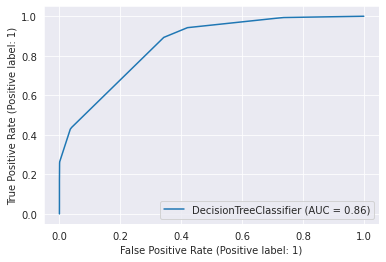

In [4]:
plot_roc_curve(clf, X_test, y_test)

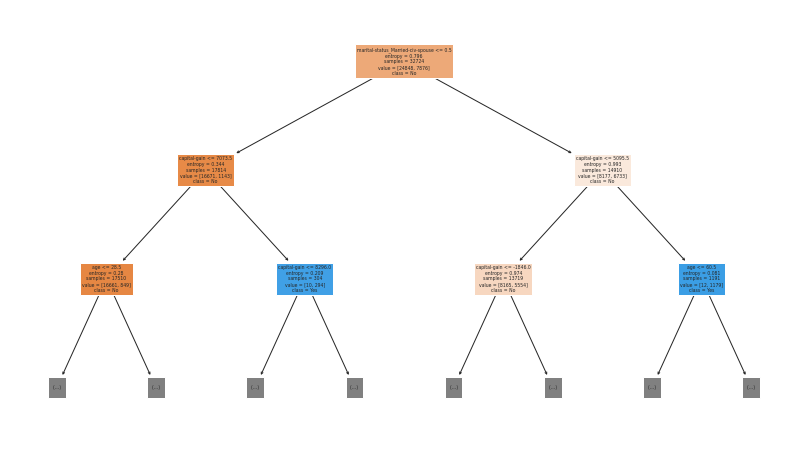

In [5]:
plt.figure(figsize=(8*(16/9), 8))
tree.plot_tree(
    clf, 
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    max_depth=2,
    filled=True
    );
plt.savefig('dectree_test.jpg', dpi=300)

In [6]:
ranked = np.argsort(clf.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
importance

,Attribute,Importance
0,marital-status_Married-civ-spouse,0.537931
1,capital-gain,0.340317
2,age,0.048072
3,education_Bachelors,0.038599
4,hours-per-week,0.034087
5,education_Preschool,0.000995


## Decision Tree: Compas Dataset

In [7]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')
label = 'two_year_recid'

features = [
    'sex',
    'age',
    'race',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]

sensitives = ['sex', 'age']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'), drop_first=True)
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

(
    X_train,
    X_test,
    y_train,
    y_test
 ) = train_test_split(X, y, test_size=test_size)

In [8]:
clf = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 4
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


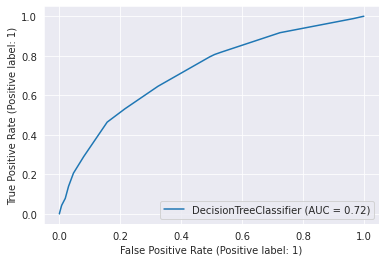

In [9]:
plot_roc_curve(clf, X_test, y_test) 

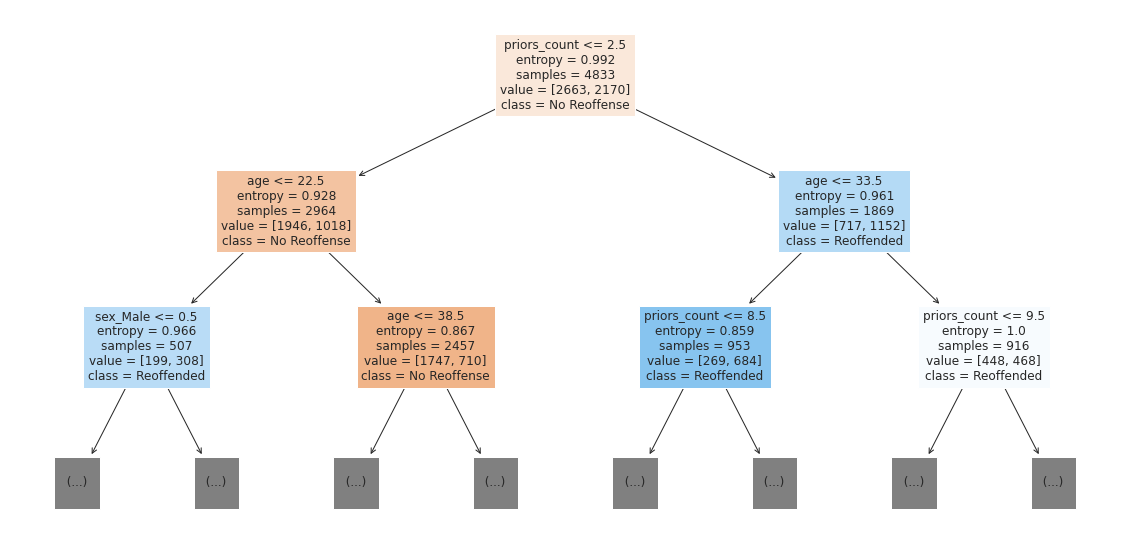

In [10]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=X.columns,
    max_depth=2,
    class_names=['No Reoffense', 'Reoffended'],
    filled=True);
plt.savefig('dectree_test.jpg', dpi=300)

In [11]:
ranked = np.argsort(clf.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
importance

,Attribute,Importance
0,priors_count,0.533148
1,age,0.432972
2,sex_Male,0.026636
3,juv_other_count,0.007244


## Decision Tree: Synthetic Datasets

In [12]:
df = pd.read_csv('data/synthethic_informative.csv', index_col=0)
label = 'Success'

sensitives = ['Sex', 'Race']
test_size = 0.33

for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

X = df.drop(label, axis=1)
y = df[label]

categorical_features = X.select_dtypes('category').columns
Xcat = pd.get_dummies(X.select_dtypes('category'))
X = X.drop(categorical_features, axis=1)
X = X.join(Xcat)

In [13]:
(
    X_train,
    X_test,
    y_train,
    y_test
 ) = train_test_split(X, y, test_size=test_size)

In [14]:
clf = DT(
    criterion = 'entropy',
    splitter = 'best',
    max_depth = 4
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


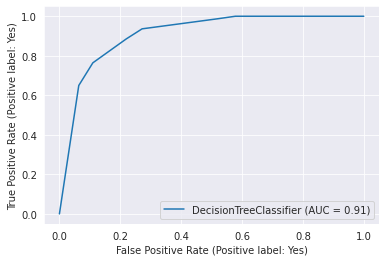

In [15]:
plot_roc_curve(clf, X_test, y_test) 

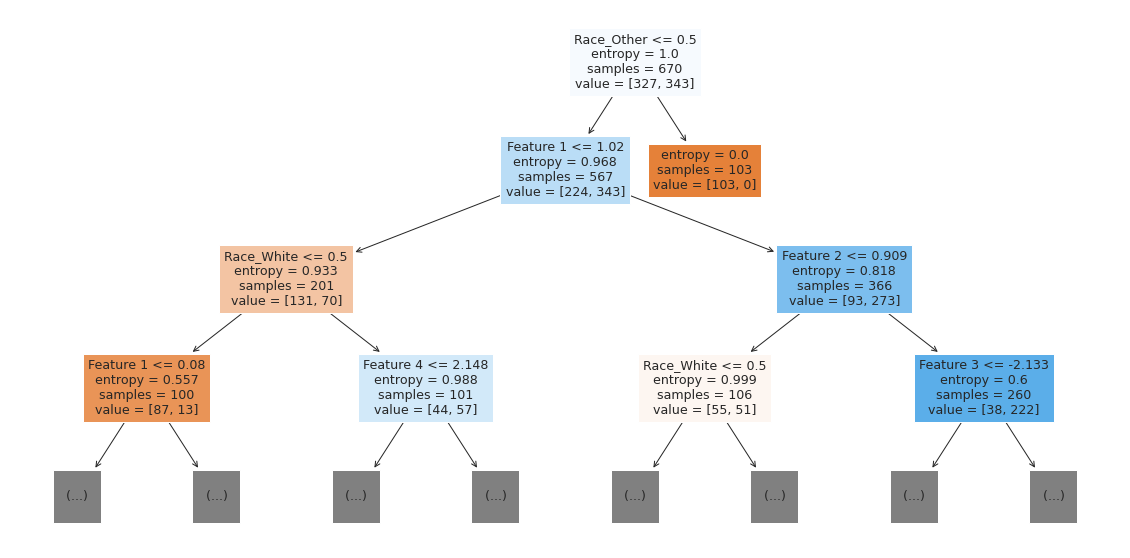

In [16]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, max_depth=3, filled=True);
plt.savefig('dectree_test.jpg', dpi=300)

In [17]:
ranked = np.argsort(clf.feature_importances_)[::-1]
names = X.columns[ranked]
values = clf.feature_importances_[ranked]

importance = pd.DataFrame(
    {
        'Attribute': names,
        'Importance': values
    }
)

importance = importance.loc[~(importance['Importance']==0.0)]
importance

,Attribute,Importance
0,Race_Other,0.367530
1,Feature 1,0.215739
2,Race_White,0.166458
3,Feature 2,0.113586
4,Feature 3,0.079879
5,Feature 4,0.056809


## Naive Bayes: Adult Dataset

In [18]:
df = pd.read_csv('data/adult.csv')
label = 'income'

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NBSens'
)

df1 = model.KLDWeights()
permw1 = model.PermutationImportance(1, 'NBSens');


  0%|          | 0/1847 [00:00<?, ?it/s]

### Naive Bayes Without Sensitive

In [ ]:
df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'
df = df.drop(sensitives, axis=1)

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NB'
)

df2 = model.KLDWeights()
permw2 = model.PermutationImportance(1, 'NB');

  0%|          | 0/1694 [00:00<?, ?it/s]

  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/1901 [00:00<?, ?it/s]

  0%|          | 0/1980 [00:00<?, ?it/s]

  0%|          | 0/2176 [00:00<?, ?it/s]

  0%|          | 0/2201 [00:00<?, ?it/s]

  0%|          | 0/2189 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2206 [00:00<?, ?it/s]

### Merge Dataframes

In [ ]:
modeldiff = df1.append(df2, ignore_index=True)
permw = permw1.append(permw2, ignore_index=True)

### Plot model difference

Text(0.5, 1.0, 'KLD on conditional probabilities - Adult Dataset')

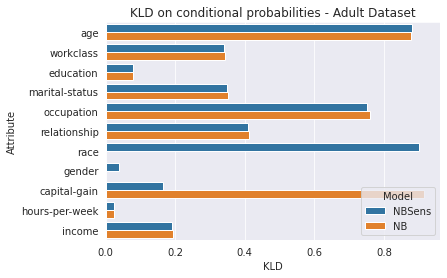

In [ ]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='KLD',
    y='Attribute',
    hue='Model',
    data=modeldiff
)

p.set_title('KLD on conditional probabilities - Adult Dataset')

Text(0.5, 1.0, 'Permutation Weights on NB - Adult Dataset')

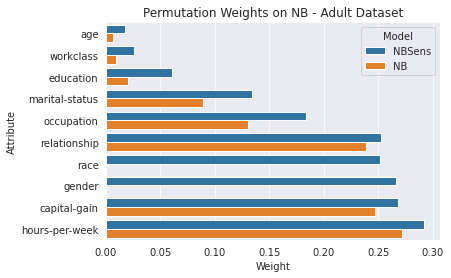

In [ ]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='Weight',
    y='Attribute',
    hue='Model',
    data=permw
)

p.set_title('Permutation Weights on NB - Adult Dataset')

## Naive Bayes: Compas Dataset

In [ ]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')

features = [
    'race',
    'sex',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]
label = 'two_year_recid'

model = interpretableNaiveBayes()

model.train(
    label,
    df,
    'NBSens'
)

df1 = model.KLDWeights()
permw1 = model.PermutationImportance(1, 'NBSens');

ValueError: Sum or integral of conditional probabilites for node juv_fel_count is not equal to 1.

In [ ]:
model.cpds[4].normalize(inplace=False).values

array([[9.70873786e-01, 9.96106424e-01],
       [9.70873786e-03, 2.92018170e-03],
       [9.70873786e-03, 6.48929267e-04],
       [9.70873786e-03, 3.24464633e-04]])

### Naive Bayes Without Sensitive

In [ ]:
df = pd.read_csv('data/compas-two-yrs-recidivism.csv')

features = [
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

df = df[features]
label = 'two_year_recid'

model = interpretableNaiveBayes()
model.train(
    label,
    df,
    'NB'
)

df2 = model.KLDWeights()
permw2 = model.PermutationImportance(1, 'NB');

ValueError: Sum or integral of conditional probabilites for node juv_fel_count is not equal to 1.

### Merge Dataframes

In [ ]:
modeldiff = df1.append(df2, ignore_index=True)
permw = permw1.append(permw2, ignore_index=True)

### Plot model difference

Text(0.5, 1.0, 'KLD on conditional probabilities - Compas Dataset')

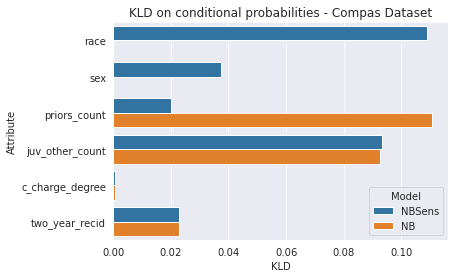

In [ ]:
sns.set_style('darkgrid')

p = sns.barplot(
    x='KLD',
    y='Attribute',
    hue='Model',
    data=modeldiff
)

p.set_title('KLD on conditional probabilities - Compas Dataset')

### 

### Fair Bayesian Network

In [ ]:
from forseti.bayesnet import latentLabelClassifier

df = pd.read_csv('data/adult.csv')
sensitives = ['gender', 'race']
label = 'income'

X = df
y = df[label]

(
    X_train,
    X_test,
    y_train,
    y_test
 ) = train_test_split(X, y, test_size=0.33)

X_test = X_test.drop(label, axis=1)

tmp_train, codes_train = translate_categorical(X_train.copy(deep=True))


clf = latentLabelClassifier(
    tmp_train,
    sensitives,
    label,
    atol=0.01
)

clf.load('trained-models/fair_model_30000.sav')

In [ ]:
faircpds = []

for cpd in clf.model.get_cpds():
    if sensitives[0] in cpd.variables or sensitives[1] in cpd.variables:
        faircpds.append(cpd)

In [ ]:
for cp in faircpds:
    print(cp)

+-----------+----------+
| gender(0) | 0.331467 |
+-----------+----------+
| gender(1) | 0.668533 |
+-----------+----------+
+-------------------+-----+-----------------+
| age               | ... | age(4)          |
+-------------------+-----+-----------------+
| fair              | ... | fair(1)         |
+-------------------+-----+-----------------+
| gender            | ... | gender(1)       |
+-------------------+-----+-----------------+
| relationship      | ... | relationship(5) |
+-------------------+-----+-----------------+
| hours-per-week(0) | ... | 0.0             |
+-------------------+-----+-----------------+
| hours-per-week(1) | ... | 1.0             |
+-------------------+-----+-----------------+
| hours-per-week(2) | ... | 0.0             |
+-------------------+-----+-----------------+
| hours-per-week(3) | ... | 0.0             |
+-------------------+-----+-----------------+
+-----------+---------------------+-----+----------------------+
| fair      | fair(0)       